# Jerk

# PID


# Algoritmo

O otimizador utilizou [Stochastic universal sampling(SUS)](https://en.wikipedia.org/wiki/Stochastic_universal_sampling)

# Parâmetros

Aqui faço a escolha de alguns parêmetros que serão utilizados bem como importo bibliotecas que serão utilizadas.

In [1]:
include("search-model.jl")
using Evolutionary;

In [2]:
Ts     = 0.05 # Intervalo entre leituras da saída
tend   = 2.0  # tempo final para estabilização
t0     = 0.0  # instante inicial
r1     = 0.6  # referência junta 1
r2     = 0.8  # referência junta 2
popul  = 50   # população
iterac = 50;   #iterações

# Gerador

Aqui criei algumas funções para serem utilizadas na geração da população inicial. Como será visto posteriormente, dependendo da função geredora inicial temos diferentes resultados, isto para o cenário de 50 iterações do algoritmo genético (valor este utilizado para obter uma saída mais rápida).

In [3]:
function gerador1(n)
    out = rand(n).*[1000., 1000., 100., 100.]
end
function gerador2(n)
    out = rand(n).*[100., 100., 100., 100.]
end
function gerador3(n)
    out = rand(n).*[10., 10., 10., 10.]
end
function gerador4(n)
    out = rand(n).*[10000., 100., 100., 100.]
end
function gerador5(n)
    out = rand(n).*[1000., 100., 1000., 100.]
end
function gerador6(n)
    out = rand(n).*[10000., 100., 1000., 100.]
end
function gerador7(n)
    out = rand(n).*[1000., 1000., 1000., 1000.]
end

gerador7 (generic function with 1 method)

# Função custo

Foram realizados teste com diferentes tipo de funções custo mas a que obteve um melhor resultado foi:

 $$ z = \alpha\sum{|e|}+\beta\sum{|J|} ,$$
onde:

- $|e|$ é o valor absoluto do erro
- $|J|$ é o valor absoluto do jerk
- $\alpha$ e $\beta$ são variáveis utilizadas para colocar todos os elementos na mesma ordem de grandeza.

Foi necessário colocar o jerk e o erro na mesma ordem de grandeza pois o algoritmo acabava privilegiando a minimização de um destes devido a grande fiferença entre eles. Outras formas foram testadas mas a que apresentou melhores resultados foi a mostrada acima.

**Outra coisa que modifica o comportamento é a parti de que instante de tempo é realizada a leitura do vetor erro, se for feita a leitura de todo o vetor, o comportamento da resposta é mais agressivo, fazendo com que chegue ao objetivo mais rápido porém com um custo de um jerk maior. O valor de 2/3 do total do vetor apresentou bons resultados.**

In [4]:
function custo(x::Vector{Float64})
    kp = SMatrix{2,2}(diagm([x[1], x[2]]))
    kv = SMatrix{2,2}(diagm([x[3], x[4]]))
    x, v, t, a, ta, j, tj = simulation(kp, kv, Ts, t0, tend, r1, r2)
    erro1 =  - (x[1] - r1)
    erro2 =  - (x[2] - r2)
    sizeVector = length(erro1)

    erro_end_1 = sum(abs.(erro1[floor(Integer,sizeVector/3):end]))
    erro_end_2 = sum(abs.(erro2[floor(Integer,sizeVector/3):end]))

    jerk_1 = sum(abs.(j[1]))
    jerk_2 = sum(abs.(j[2]))

    erro_end = erro_end_1 + erro_end_2
    jerk = jerk_1 + jerk_2

    erro_end = erro_end*10.
    jerk = jerk*0.01

    out =  erro_end + jerk
    #println(" $(erro_end) | $(jerk) | $(out)")
    out
    end;


# Simulação

**Aqui é realizada a simulação para o algoritmo de controle com o otimizador.**

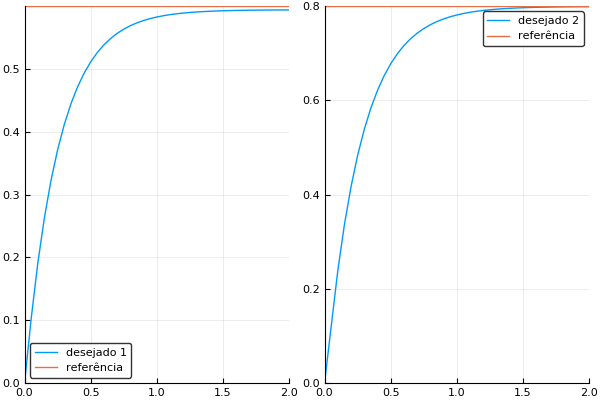

In [5]:
N = 4
 result, fitness, cnt = ga(custo, N; initPopulation = gerador6, populationSize = popul, ɛ = 0.1, selection = roulette, crossover = intermediate(0.25), mutation = domainrange(fill(0.5,N)), iterations = iterac)
# result, fitness, cnt = ga(custo, N; initPopulation = gerador6, populationSize = popul, ɛ = 0.1, selection = sus, crossover = intermediate(0.25), mutation = domainrange(fill(0.5,N)), iterations = iterac)
t_end_new = tend 
kp = SMatrix{2,2}(diagm(result[1:2]))
kv = SMatrix{2,2}(diagm(result[3:4]))

x, v, t, a, ta, j, tj = simulation(kp, kv, Ts, t0, t_end_new, r1, r2);

table1 = "|-------- | junta 1  | junta 2 |
|--------| ------------- | ------------- |
|**erro final**| $(rad2deg(x[1][end] - r1)) graus  | $(rad2deg(x[2][end] - r2)) graus  |
|**total jerk **| $(sum(abs.(j[1])))  rad/sec³  | $(sum(abs.(j[2])))  rad/sec³  |
|**máximo jerk**| $(maximum(abs.(j[1])))  rad/sec³  | $(maximum(abs.(j[2])))  rad/sec³ |"

function plotx()
    p1 = plot(t,x[1], label = "desejado 1")
    p1= plot!([r1],seriestype= :hline, label = "referência");
    p2 = plot(t,x[2], label = "desejado 2")
    p2 = plot!([r2],seriestype= :hline, label = "referência");
    plot(p1,p2)
end

function plotj()
    p1 = plot(tj,j[1], label = "jerk 1")
    p2 = plot(tj,j[2], label = "jerk 2")
    plot(p1,p2)
end;

plotx()

**A tabela a seguir apresenta um resumo dos resultados para o PID otimizado.**

In [6]:
Markdown.parse(table1)

|            –––– |                      junta 1 |                      junta 2 |
| ---------------:| ----------------------------:| ----------------------------:|
|  **erro final** |    -0.3622724451947621 graus |   -0.08638241112089758 graus |
| **total jerk ** | 1081.0475097262295  rad/sec³ | 1358.4693718903536  rad/sec³ |
| **máximo jerk** |  932.4208680170358  rad/sec³ | 1191.6144220651022  rad/sec³ |


# PID clássico

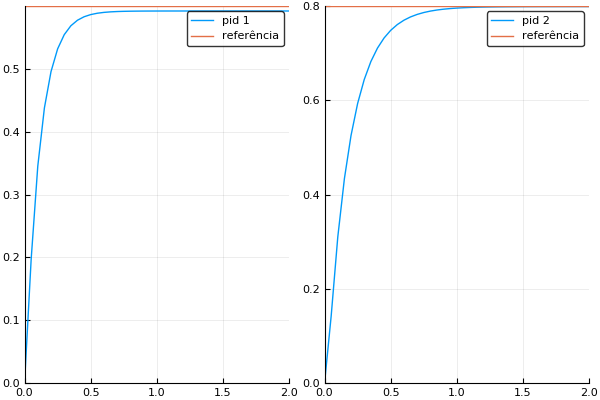

In [7]:
kp_pid = SMatrix{2,2}(diagm([2800., 80.]))
kv_pid = SMatrix{2,2}(diagm([315., 15.]))
x_pid, v_pid, t_pid, a_pid, ta_pid, j_pid, tj_pid = simulation(kp_pid, kv_pid, Ts, t0, tend, r1, r2)
erro1 = -(x_pid[1] - r1)
erro2 = -(x_pid[2] - r2)
table2 = "|-------- | junta 1  | junta 2 |
|--------| ------------- | ------------- |
|**erro final**| $(rad2deg(x_pid[1][end] - r1)) graus  | $(rad2deg(x_pid[2][end] - r2)) graus  |
|**total jerk **| $(sum(abs.(j_pid[1])))  rad/sec³  | $(sum(abs.(j_pid[2])))  rad/sec³  |
|**máximo jerk**| $(maximum(abs.(j_pid[1])))  rad/sec³  | $(maximum(abs.(j_pid[2])))  rad/sec³ |"

p1 = plot(t_pid,x_pid[1], label = "pid 1")
p1= plot!([r1],seriestype= :hline, label = "referência");
p2 = plot(t_pid,x_pid[2], label = "pid 2")
p2 = plot!([r2],seriestype= :hline, label = "referência");

plot(p1,p2)


**A tabela a seguir apresenta um resumo dos resultados para o PID clássico.**

In [8]:
Markdown.parse(table2)


|            –––– |                      junta 1 |                      junta 2 |
| ---------------:| ----------------------------:| ----------------------------:|
|  **erro final** |   -0.46087349666293315 graus |   -0.07844262693506009 graus |
| **total jerk ** | 2588.7400924277417  rad/sec³ |   2353.94314070317  rad/sec³ |
| **máximo jerk** | 2035.2352092288643  rad/sec³ | 1950.6663211035006  rad/sec³ |


# Comparação

**PID ótimo**

In [9]:
Markdown.parse(table1)

|            –––– |                      junta 1 |                      junta 2 |
| ---------------:| ----------------------------:| ----------------------------:|
|  **erro final** |    -0.3622724451947621 graus |   -0.08638241112089758 graus |
| **total jerk ** | 1081.0475097262295  rad/sec³ | 1358.4693718903536  rad/sec³ |
| **máximo jerk** |  932.4208680170358  rad/sec³ | 1191.6144220651022  rad/sec³ |


**PID clássico**

In [10]:
Markdown.parse(table2)

|            –––– |                      junta 1 |                      junta 2 |
| ---------------:| ----------------------------:| ----------------------------:|
|  **erro final** |   -0.46087349666293315 graus |   -0.07844262693506009 graus |
| **total jerk ** | 2588.7400924277417  rad/sec³ |   2353.94314070317  rad/sec³ |
| **máximo jerk** | 2035.2352092288643  rad/sec³ | 1950.6663211035006  rad/sec³ |
